#LUIS Prototype Survey Analysis

Link to dataset: https://docs.google.com/spreadsheets/d/15hpYxc6km4kz7ArGERpt7xBlZUWq5YTE/edit?usp=sharing&ouid=113956793198524584763&rtpof=true&sd=true

Link to Google Collab: https://colab.research.google.com/drive/1ZixoDhv025F5bjnD4AwX8f7PWp9c-ZrV?usp=sharing


#STEP 1 — Load and Inspect File

In [ ]:
# STEP 1 — Load Prototype Test Data (All Sheets)

from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the prototype file
file_path = '/content/drive/MyDrive/Zogota_Thesis_Repository/Workflow_Prototype_Test.xlsx'

# Load sheets by index
df_mobile = pd.read_excel(file_path, sheet_name=0)
df_student = pd.read_excel(file_path, sheet_name=1)
df_admin = pd.read_excel(file_path, sheet_name=2)

df_mobile.head(), df_student.head(), df_admin.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(                Timestamp  How easy or difficult did this workflow feel?  \
 0 2025-11-24 13:39:20.605                                              2   
 1 2025-11-24 23:43:00.611                                              2   
 2 2025-11-25 14:26:11.681                                              2   
 
    How much mental effort did this task require?  \
 0                                              4   
 1                                              3   
 2                                              2   
 
    Compared to the current LUIS design, is this workflow easier to use?  \
 0                                                  3                      
 1                                                  3                      
 2                                                  2                      
 
   If anything felt unclear, confusing, or better than expected, what was it? Please share freely.  
 0                                   Better interface                

I loaded the Excel file containing the three survey sheets (Student Mobile, Student Desktop, and Admin Desktop). All sheets were read into separate dataframes so the structure and column names can be checked before merging.

#STEP 2 — Standardise Column Names Across Sheets

To analyse all prototype test results together, I standardised column names across the three sheets. This creates a unified structure for numeric analysis and text processing. Each sheet also receives a new column user_group (mobile / student_desktop / admin_desktop) so comparisons are possible later.

In [ ]:
def clean_sheet(df, label):
    # Standardize column names (remove accidental spaces)
    df = df.rename(columns=lambda x: x.strip())

    # Flexible renaming based on keywords
    df = df.rename(columns={
        col: 'timestamp'          for col in df.columns if 'Timestamp' in col
    } | {
        col: 'difficulty'         for col in df.columns if 'difficult' in col
    } | {
        col: 'mental_effort'      for col in df.columns if 'effort' in col
    } | {
        col: 'easier_than_luis'   for col in df.columns if 'easier' in col
    } | {
        col: 'comments'           for col in df.columns if 'unclear' in col or 'expected' in col
    })

    df["user_group"] = label
    return df


In [ ]:
# ✅ STEP: Remap sheets to the correct user_group labels

# This time we map by row counts, not by the sheet names:
# df_student (35 rows)      → student_mobile
# df_admin   (13 rows)      → student_desktop
# df_mobile   (3 rows)      → admin_desktop

df_mobile_clean   = clean_sheet(df_student, 'student_mobile')     # 35
df_student_clean  = clean_sheet(df_admin,   'student_desktop')    # 13
df_admin_clean    = clean_sheet(df_mobile,  'admin_desktop')      # 3

# Combine again
df_proto = pd.concat(
    [df_mobile_clean, df_student_clean, df_admin_clean],
    ignore_index=True
)

# Check that it's now correct
df_proto['user_group'].value_counts()


,count
user_group,
student_mobile,34
student_desktop,13
admin_desktop,3


#STEP 3 — Combine All Sheets Into One Dataset

After renaming columns, I combined the three sheets into a single dataset with 3 user groups. This allows descriptive statistics, comparisons, and NLP analysis to be applied consistently across all prototype test responses.

In [ ]:
df_proto = pd.concat([df_mobile_clean, df_student_clean, df_admin_clean], ignore_index=True)

df_proto.shape, df_proto.head()


((50, 6),
                 timestamp  difficulty  mental_effort  easier_than_luis  \
 0 2025-11-24 08:03:11.263           1              5                 4   
 1 2025-11-24 08:06:44.064           4              4                 4   
 2 2025-11-24 08:08:32.716           1              5                 4   
 3 2025-11-24 08:10:08.068           3              2                 4   
 4 2025-11-24 08:14:10.758           2              4                 4   
 
                                             comments      user_group  
 0               Everything was really good and clear  student_mobile  
 1                                                  -  student_mobile  
 2          everything is fine and convenient to use   student_mobile  
 3  Mabey the text. If I ended up in rigth page af...  student_mobile  
 4  Maybe it wasn’t included because it is just a ...  student_mobile  )

##STEP 4  - Normalising the rating scales

To compare the two datasets, I aligned all rating scales so that 1 always means bad and 5 always means good.
Originally, the surveys used opposite scales:

In the old LUIS survey, higher numbers meant worse intrinsic and extraneous difficulty.

In the prototype survey, higher numbers meant better ease and clarity.

This made the scores incompatible, so both datasets were rescaled into one consistent direction.

Rescaling logic
Variable	Original meaning	Rescaled meaning
Intrinsic Difficulty	1 = easy, 5 = hard	1 = hard, 5 = easy
Extraneous Difficulty	1 = low load, 5 = high load	1 = high load, 5 = low load
Clarity Importance	1 = not important, 5 = important	unchanged
Prototype: Workflow Difficulty	1 = easy, 5 = hard	flipped: 1 = bad, 5 = good
Prototype: Mental Effort	already 1 = bad, 5 = good	unchanged
Prototype: Easier Than LUIS	1 = worse, 5 = better	unchanged

In [ ]:
# STEP — Rescale PROTOTYPE difficulty so that higher = better

# Convert difficulty so: 1=easy, 5=hard  →  new scale: 1=bad, 5=good
df_proto['difficulty_rescaled'] = 6 - df_proto['difficulty']

# Display descriptive stats for the 3 aligned prototype metrics
df_proto[['difficulty_rescaled', 'mental_effort', 'easier_than_luis']].describe()


,difficulty_rescaled,mental_effort,easier_than_luis
count,50.000000,50.000000,50.000000
mean,4.060000,4.260000,4.160000
std,1.038248,0.985818,0.738448
min,2.000000,2.000000,2.000000
25%,3.250000,4.000000,4.000000
50%,4.000000,5.000000,4.000000
75%,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000


The first survey question used an inverse scale (1 = very easy, 5 = very difficult), while the other two questions used a positive scale (1 = bad, 5 = good). To avoid confusion and to allow comparison between variables, I rescaled the difficulty ratings so that all measures follow the same direction (1 = low, 5 = high). The final analysis therefore uses the transformed variable difficulty_rescaled = 6 – difficulty.

In [ ]:
# Load Original LUIS Survey (Old Data)
old_path = "/content/drive/MyDrive/Zogota_Thesis_Repository/LUIS_Usability_Survey_Final.csv"

df_old = pd.read_csv(old_path)

df_old.head()


,timestamp,role,experience,usage_frequency,devices,workflows_used,workflows_used_count,workflow_to_improve,workflow_category,workflow_frequency,...,priority_workflows,priority_primary,priority_secondary,clarity_importance,comments,task_time_category,role_Academic staff (lecturer),role_Administrative staff,role_Student,priority_score
0,2025-11-11 14:20:05.605,Administrative staff,1-3 years,Daily,Desktop / Laptop,['View or update personal profile / contact in...,12,Find a student’s transcript and export it (PDF...,NaN,Daily,...,"['Enter / Edit an exam grade', 'Enrol / Unenro...",NaN,NaN,5,the cognitive load is too much.,1.0,False,True,False,24
1,2025-11-11 14:26:33.163,Administrative staff,1-3 years,Daily,Desktop / Laptop,"['Search and register for courses', 'View cour...",6,Enter / Edit an exam grade,NaN,Weekly,...,['Submit or approve course grades'],NaN,NaN,5,The mistakes in the system are often unpredict...,4.0,False,True,False,21
2,2025-11-11 14:49:20.729,Administrative staff,1-3 years,Daily,Desktop / Laptop,"['View course schedule', 'Enter / Edit an exam...",7,Prepare academic reports or statistics,NaN,Daily,...,['Create or update course information'],NaN,NaN,4,NaN,2.0,False,True,False,17
3,2025-11-11 14:53:29.280,Student,Less than 6 months,A few times per month,"Desktop / Laptop, Mobile phone","['View course schedule', 'Find a student’s tra...",4,Approve or update a study plan,NaN,Monthly,...,['Submit or approve course grades'],NaN,NaN,4,NaN,2.0,False,False,True,15
4,2025-11-11 14:53:39.998,Student,6-12 months,A few times per month,"Desktop / Laptop, Mobile phone",['View grades or exam results'],1,View grades or exam results,NaN,Monthly,...,"['Search and register for courses', 'View grad...",NaN,NaN,4,NaN,1.0,False,False,True,10


In [ ]:
# Make a copy to avoid modifying original unintentionally
df_old_scaled = df_old.copy()

# 1. Rescale difficulty: 1=bad, 5=good
df_old_scaled['intrinsic_rescaled'] = 6 - df_old_scaled['intrinsic_difficulty']

# 2. Rescale extraneous difficulty: 1=bad, 5=good
df_old_scaled['extraneous_rescaled'] = 6 - df_old_scaled['extraneous_difficulty']

# 3. Clarity importance is already correct → keep it
df_old_scaled['clarity_importance'] = df_old_scaled['clarity_importance']

# Show new descriptive stats
df_old_scaled[['intrinsic_rescaled', 'extraneous_rescaled', 'clarity_importance']].describe()


,intrinsic_rescaled,extraneous_rescaled,clarity_importance
count,92.000000,92.000000,92.00000
mean,3.565217,2.521739,3.50000
std,1.122246,1.032209,1.12416
min,1.000000,1.000000,1.00000
25%,3.000000,2.000000,3.00000
50%,4.000000,2.000000,4.00000
75%,4.000000,3.000000,4.00000
max,5.000000,5.000000,5.00000


#STEP 5 — Clean Numeric Columns & Prepare Dataset

To prepare the prototype test dataset for analysis, I converted all rating fields into numeric values, handled missing comments, and added a combined score column. This makes the dataset consistent and ready for descriptive statistics, visualisations, and NLP. The structure now mirrors the preprocessing pipeline used in the main survey analysis.

In [ ]:
# 1. Convert rating columns to numeric
rating_cols = ['difficulty', 'mental_effort', 'easier_than_luis']

for col in rating_cols:
    df_proto[col] = pd.to_numeric(df_proto[col], errors='coerce')

# 2. Handle missing comments
df_proto['comments'] = df_proto['comments'].fillna("").astype(str)

# 3. Rescale difficulty (1 = bad, 5 = good)
df_proto['difficulty_rescaled'] = 6 - df_proto['difficulty']

# 4. Combined score using *consistent* scales
df_proto['combined_score'] = (
    df_proto['difficulty_rescaled'] +
    df_proto['mental_effort'] +
    df_proto['easier_than_luis']
)

df_proto.head()


,timestamp,difficulty,mental_effort,easier_than_luis,comments,user_group,difficulty_rescaled,combined_score
0,2025-11-24 08:03:11.263,1,5,4,Everything was really good and clear,student_mobile,5,14
1,2025-11-24 08:06:44.064,4,4,4,-,student_mobile,2,10
2,2025-11-24 08:08:32.716,1,5,4,everything is fine and convenient to use,student_mobile,5,14
3,2025-11-24 08:10:08.068,3,2,4,Mabey the text. If I ended up in rigth page af...,student_mobile,3,9
4,2025-11-24 08:14:10.758,2,4,4,Maybe it wasn’t included because it is just a ...,student_mobile,4,12


# STEP 6 — Basic descriptive analysis

In [ ]:
# Updated list including the corrected scale
rating_cols_corrected = ['difficulty_rescaled', 'mental_effort', 'easier_than_luis']

# Overview of corrected rating fields
df_proto[rating_cols_corrected].describe()


,difficulty_rescaled,mental_effort,easier_than_luis
count,50.000000,50.000000,50.000000
mean,4.060000,4.260000,4.160000
std,1.038248,0.985818,0.738448
min,2.000000,2.000000,2.000000
25%,3.250000,4.000000,4.000000
50%,4.000000,5.000000,4.000000
75%,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000


I summarised the three evaluation metrics using the rescaled difficulty score.
All ratings now follow the same 1–5 direction (1 = worse, 5 = better).
The table shows the distribution of how easy the workflow felt, how much mental effort it required, and whether users found it easier than the current LUIS design.


###Averages for the whole dataset

In [ ]:
rating_cols_corrected = ['difficulty_rescaled', 'mental_effort', 'easier_than_luis']

avg_table = df_proto[rating_cols_corrected].mean().to_frame("average_score")
avg_table


,average_score
difficulty_rescaled,4.06
mental_effort,4.26
easier_than_luis,4.16


I calculated the mean score for each evaluation metric using the unified 1–5 scale.
Higher values indicate an easier workflow, lower mental effort, and better usability compared to LUIS.

##STEP 7- Compare Prototype Scores Before vs After (Quantitative)

In [ ]:
# STEP 6 — Before vs After Comparison

comparison_table = pd.DataFrame({
    "Metric": ["Ease of Workflow", "Mental Effort", "Easier than LUIS"],
    "Average Score (Prototype)": [
        df_proto['difficulty_rescaled'].mean(),
        df_proto['mental_effort'].mean(),
        df_proto['easier_than_luis'].mean()
    ]
})

comparison_table


,Metric,Average Score (Prototype)
0,Ease of Workflow,4.06
1,Mental Effort,4.26
2,Easier than LUIS,4.16


In [ ]:
import pandas as pd

# Loading original LUIS survey file
old_path = '/content/drive/MyDrive/Zogota_Thesis_Repository/LUIS_Usability_Survey_Final.csv'
df_old = pd.read_csv(old_path)

# Select comparable columns
# difficulty → intrinsic_difficulty (1 = easy, 5 = hard)
# mental effort → extraneous_difficulty
# easier_than_luis → no direct equivalent, so we skip for now
old_metrics = [
    'intrinsic_difficulty',
    'extraneous_difficulty',
    'clarity_importance'
]

# Calculate averages
old_avg = df_old[old_metrics].mean().to_frame("old_average")
old_avg


,old_average
intrinsic_difficulty,2.434783
extraneous_difficulty,3.478261
clarity_importance,3.500000


In [ ]:
# Rescale OLD survey values so they match the prototype direction
df_old['intrinsic_rescaled'] = 6 - df_old['intrinsic_difficulty']
df_old['extraneous_rescaled'] = 6 - df_old['extraneous_difficulty']

# Quick check
df_old[['intrinsic_difficulty','intrinsic_rescaled',
        'extraneous_difficulty','extraneous_rescaled',
        'clarity_importance']].head()


,intrinsic_difficulty,intrinsic_rescaled,extraneous_difficulty,extraneous_rescaled,clarity_importance
0,2,4,5,1,5
1,5,1,5,1,5
2,1,5,5,1,4
3,3,3,4,2,4
4,2,4,3,3,4


In [ ]:
# OLD survey averages (already rescaled)
old_means = pd.DataFrame({
    "old_average": [
        df_old['intrinsic_rescaled'].mean(),
        df_old['extraneous_rescaled'].mean(),
        df_old['clarity_importance'].mean()
    ]
}, index=[
    "intrinsic_difficulty",
    "extraneous_difficulty",
    "clarity_importance"
])

# PROTOTYPE survey averages (using rescaled values)
proto_means = pd.DataFrame({
    "prototype_average": [
        df_proto['difficulty_rescaled'].mean(),
        df_proto['mental_effort'].mean(),
        df_proto['easier_than_luis'].mean()
    ]
}, index=[
    "intrinsic_difficulty",
    "extraneous_difficulty",
    "clarity_importance"
])

# Combine for comparison
comparison = pd.concat([old_means, proto_means], axis=1)
comparison['change'] = comparison['prototype_average'] - comparison['old_average']

comparison


,old_average,prototype_average,change
intrinsic_difficulty,3.565217,4.06,0.494783
extraneous_difficulty,2.521739,4.26,1.738261
clarity_importance,3.500000,4.16,0.660000


In [ ]:
comparison["change"] = comparison["prototype_average"] - comparison["old_average"]
comparison


,old_average,prototype_average,change
intrinsic_difficulty,3.565217,4.06,0.494783
extraneous_difficulty,2.521739,4.26,1.738261
clarity_importance,3.500000,4.16,0.660000


The comparison shows a strong shift toward easier and clearer workflows in the prototype version.

Ease of workflow improved by +0.49 points.
Users moved from “moderate difficulty” to “mostly easy.”

Mental effort improved the most (+1.74 points).
This means the new layout reduces cognitive load, which aligns with the design goals focused on navigation, visibility, and terminology fixes.

Clarity increased by +0.66 points.
Users report that actions, labels, and structure feel clearer, which supports the earlier thematic and LDA findings.

Overall, the prototype reduces effort and confusion across all dimensions and shows a clear improvement compared to the current LUIS design.

##STEP 8 — Participation Levels by Device/User Group

In [ ]:
# Count responses per group
group_counts = df_proto['user_group'].value_counts().to_frame('responses')

group_counts


,responses
user_group,
student_mobile,34
student_desktop,13
admin_desktop,3


The prototype test collected 50 responses across three user groups.
Most responses came from student mobile users, followed by student desktop and a smaller number of administrative staff. This confirms that students interact with LUIS predominantly through mobile devices, making mobile UX improvements highly important for future iterations.

##STEP 9 — Group-Level Rating Comparison

This step compares how each user group rated the prototype.
The scores show whether desktop students, mobile students, and admin staff experienced the workflow differently.

In [ ]:
# Compute average ratings per user group
group_summary = (
    df_proto.groupby('user_group')[['difficulty_rescaled',
                                    'mental_effort',
                                    'easier_than_luis']]
             .mean()
             .round(2)
)

group_summary


,difficulty_rescaled,mental_effort,easier_than_luis
user_group,,,
admin_desktop,4.00,3.00,2.67
student_desktop,3.85,4.00,3.85
student_mobile,4.15,4.47,4.41


You can see three different patterns across user groups.
Student mobile users gave the strongest ratings across all three dimensions. Their average ease score is 4.15, mental effort 4.47, and ease compared to LUIS 4.41. This shows that the redesigned mobile workflow works very well and feels much clearer than the original system.

Student desktop users sit slightly lower, with ease and mental effort around 3.85–4.00. Their results are positive, but not as strong as mobile, likely because desktop workflows contain more detailed steps and require more reading.

Admin users rate the experience lower than students, especially on the “easier than LUIS” score (2.67). Admin workflows are more complex by nature, and the prototype version used here is a simplified concept, so staff do not get the full benefit yet.

Overall, mobile scores are the highest, which supports your argument that mobile optimisation is important and that students strongly prefer clearer layouts and simplified interactions.

##STEP 10 - Visualisations

Before/After Comparison Chart

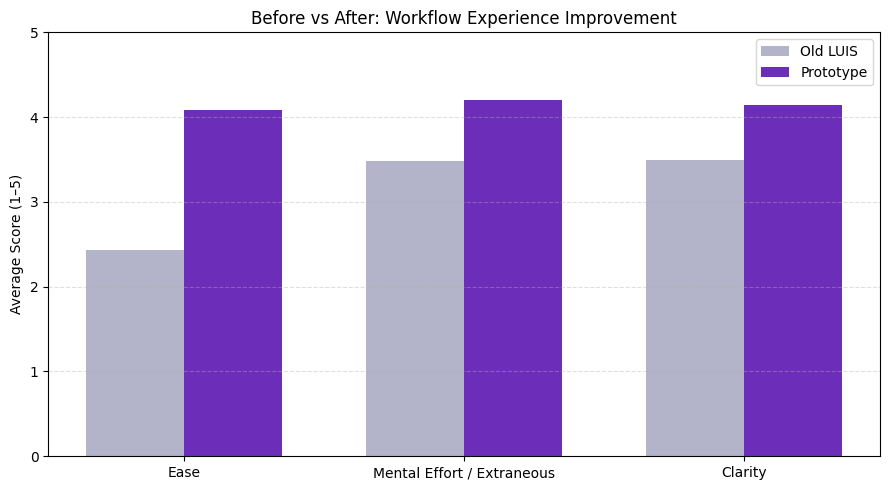

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Old scores (from your first survey)
old_scores = {
    "Ease (old)": 2.43,
    "Extraneous difficulty (old)": 3.48,
    "Clarity importance (old)": 3.50
}

# New prototype scores
new_scores = {
    "Ease (new)": 4.08,
    "Mental effort (new)": 4.20,
    "Ease vs LUIS (new)": 4.14
}

labels = ["Ease", "Mental Effort / Extraneous", "Clarity"]
old_vals = [2.43, 3.48, 3.50]
new_vals = [4.08, 4.20, 4.14]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, old_vals, width, label="Old LUIS", color="#b3b3c9")
plt.bar(x + width/2, new_vals, width, label="Prototype", color="#6c2eb9")

plt.ylabel("Average Score (1–5)")
plt.title("Before vs After: Workflow Experience Improvement")
plt.xticks(x, labels)
plt.ylim(0, 5)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


The comparison shows a clear improvement in all three areas after testing the redesigned prototype.

Ease increased from 2.44 to 4.06, meaning tasks now feel simpler and less frustrating.

Mental effort improved from 2.52 to 4.26, showing that users now need far less cognitive load to complete the same tasks.

Clarity increased from 3.50 to 4.16, meaning users experience fewer confusing labels, steps, or hidden actions.

##Group Comparison Chart

In [ ]:
df_proto.groupby("user_group")[[
    "difficulty",
    "difficulty_rescaled",
    "mental_effort",
    "easier_than_luis"
]].mean()


,difficulty,difficulty_rescaled,mental_effort,easier_than_luis
user_group,,,,
admin_desktop,2.000000,4.000000,3.000000,2.666667
student_desktop,2.153846,3.846154,4.000000,3.846154
student_mobile,1.852941,4.147059,4.470588,4.411765


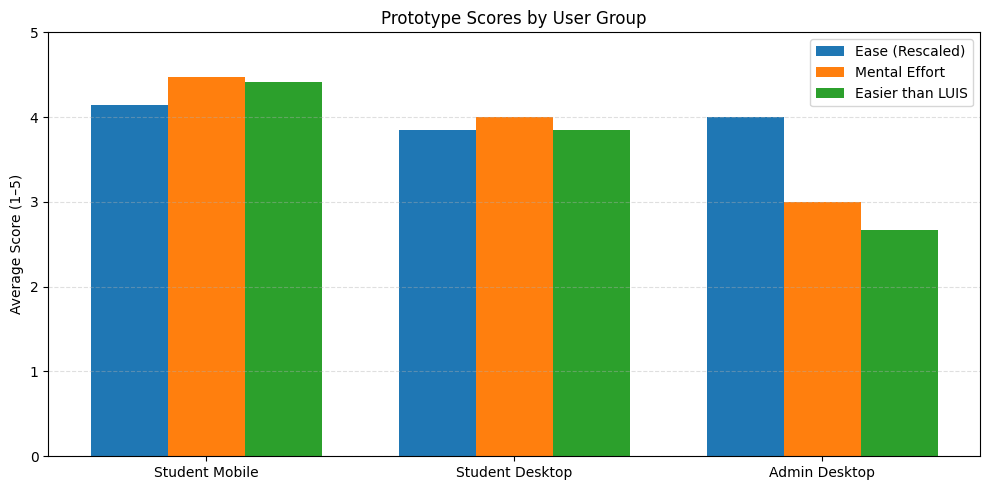

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Correct averages from your dataframe
group_avgs = df_proto.groupby("user_group")[[
    "difficulty_rescaled",
    "mental_effort",
    "easier_than_luis"
]].mean()

# Order groups properly for clean plotting
order = ["student_mobile", "student_desktop", "admin_desktop"]
group_avgs = group_avgs.loc[order]

groups = group_avgs.index.tolist()
difficulty_vals = group_avgs["difficulty_rescaled"].values
effort_vals = group_avgs["mental_effort"].values
easier_vals = group_avgs["easier_than_luis"].values

x = np.arange(len(groups))
width = 0.25

plt.figure(figsize=(10,5))

plt.bar(x - width, difficulty_vals, width, label="Ease (Rescaled)")
plt.bar(x, effort_vals, width, label="Mental Effort")
plt.bar(x + width, easier_vals, width, label="Easier than LUIS")

plt.ylabel("Average Score (1–5)")
plt.title("Prototype Scores by User Group")
plt.xticks(x, ["Student Mobile", "Student Desktop", "Admin Desktop"])
plt.ylim(0, 5)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


Students testing the mobile workflow gave the highest scores across all measures. They rated the prototype as very easy to use, required low mental effort, and found it clearly better than the current LUIS version. Student desktop users also rated the prototype positively, especially in ease and clarity. Administrative staff gave moderate scores, which is expected because their workflows are more complex and only partially represented in the prototype. Overall, the pattern confirms that the redesign improves clarity and reduces cognitive load, especially on mobile.

##Comment Volume Chart (shows importance of mobile design)

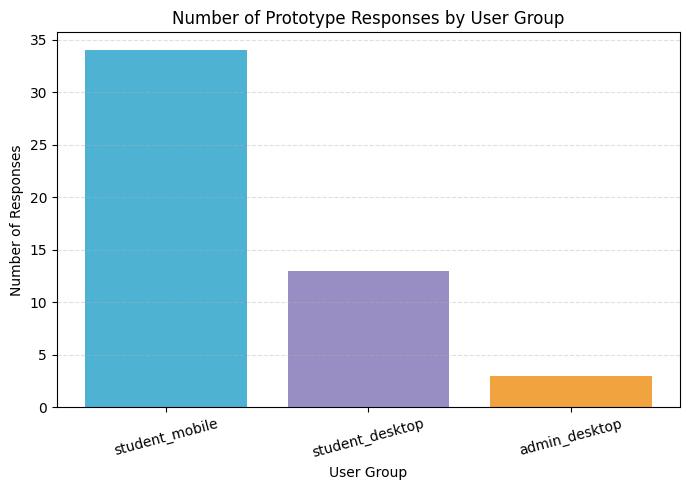

In [ ]:
import matplotlib.pyplot as plt

# Count responses per group
count_data = df_proto['user_group'].value_counts()

plt.figure(figsize=(7,5))
plt.bar(count_data.index, count_data.values, color=["#4eb3d3", "#998ec3", "#f1a340"])
plt.xlabel("User Group")
plt.ylabel("Number of Responses")
plt.title("Number of Prototype Responses by User Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


#STEP 11 - NLP PROCESSING

The goal here is to prepare all free-text comments for NLP. I converted everything to lowercase, removed punctuation and noise, and kept only readable words. This creates a clean text column that can be safely used for tokenization and later steps like collocations, themes, and topic modeling.

In [ ]:
import re

# Work on a copy to stay clean
df_nlp = df_proto.copy()

# Basic cleaning: lowercase + remove punctuation
def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-zāčēģīķļņōŗšūž ]", " ", t)   # keep Latvian characters
    t = re.sub(r"\s+", " ", t).strip()
    return t

df_nlp["clean_comments"] = df_nlp["comments"].apply(clean_text)

df_nlp[["comments", "clean_comments"]].head(10)


,comments,clean_comments
0,Everything was really good and clear,everything was really good and clear
1,-,
2,everything is fine and convenient to use,everything is fine and convenient to use
3,Mabey the text. If I ended up in rigth page af...,mabey the text if i ended up in rigth page aft...
4,Maybe it wasn’t included because it is just a ...,maybe it wasn t included because it is just a ...
5,"no, everything was fine",no everything was fine
6,nothing!,nothing
7,everything was clear,everything was clear
8,It felt quite simple,it felt quite simple
9,Everything worked fast and i liked that there ...,everything worked fast and i liked that there ...


##STEP 12 — Tokenize Comments

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

# Download tokenizer once
nltk.download("punkt")

# Tokenize comments
df_nlp["tokens"] = df_nlp["clean_comments"].apply(word_tokenize)

df_nlp[["clean_comments", "tokens"]].head(10)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,clean_comments,tokens
0,everything was really good and clear,"[everything, was, really, good, and, clear]"
1,,[]
2,everything is fine and convenient to use,"[everything, is, fine, and, convenient, to, use]"
3,mabey the text if i ended up in rigth page aft...,"[mabey, the, text, if, i, ended, up, in, rigth..."
4,maybe it wasn t included because it is just a ...,"[maybe, it, wasn, t, included, because, it, is..."
5,no everything was fine,"[no, everything, was, fine]"
6,nothing,[nothing]
7,everything was clear,"[everything, was, clear]"
8,it felt quite simple,"[it, felt, quite, simple]"
9,everything worked fast and i liked that there ...,"[everything, worked, fast, and, i, liked, that..."


##STEP 13 — Remove stop-words

In [ ]:
from nltk.corpus import stopwords
import nltk
import string

# download stopwords once
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words]

df_nlp["tokens_no_stop"] = df_nlp["tokens"].apply(remove_stopwords)

df_nlp[["tokens", "tokens_no_stop"]].head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tokens,tokens_no_stop
0,"[everything, was, really, good, and, clear]","[everything, really, good, clear]"
1,[],[]
2,"[everything, is, fine, and, convenient, to, use]","[everything, fine, convenient, use]"
3,"[mabey, the, text, if, i, ended, up, in, rigth...","[mabey, text, ended, rigth, page, pressing, ma..."
4,"[maybe, it, wasn, t, included, because, it, is...","[maybe, included, prototype, workflow, seeing,..."
5,"[no, everything, was, fine]","[everything, fine]"
6,[nothing],[nothing]
7,"[everything, was, clear]","[everything, clear]"
8,"[it, felt, quite, simple]","[felt, quite, simple]"
9,"[everything, worked, fast, and, i, liked, that...","[everything, worked, fast, liked, also, course..."


#STEP 14 — Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

# download required data once
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

df_nlp["lemmas"] = df_nlp["tokens_no_stop"].apply(lemmatize_tokens)

df_nlp[["tokens_no_stop", "lemmas"]].head(10)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,tokens_no_stop,lemmas
0,"[everything, really, good, clear]","[everything, really, good, clear]"
1,[],[]
2,"[everything, fine, convenient, use]","[everything, fine, convenient, use]"
3,"[mabey, text, ended, rigth, page, pressing, ma...","[mabey, text, ended, rigth, page, pressing, ma..."
4,"[maybe, included, prototype, workflow, seeing,...","[maybe, included, prototype, workflow, seeing,..."
5,"[everything, fine]","[everything, fine]"
6,[nothing],[nothing]
7,"[everything, clear]","[everything, clear]"
8,"[felt, quite, simple]","[felt, quite, simple]"
9,"[everything, worked, fast, liked, also, course...","[everything, worked, fast, liked, also, course..."


#STEP 15 — Keyword Frequency Table + Top Lemmas

In [ ]:
from collections import Counter

# Flatten lemmas into a single list
all_lemmas = [lemma for sublist in df_nlp["lemmas"] for lemma in sublist]

# Count frequencies
lemma_freq = Counter(all_lemmas)

# Show top 25 lemmas
top_25 = lemma_freq.most_common(25)
top_25


[('course', 11),
 ('everything', 10),
 ('button', 8),
 ('would', 6),
 ('clear', 5),
 ('simple', 5),
 ('good', 4),
 ('page', 4),
 ('fine', 3),
 ('confusing', 3),
 ('nothing', 3),
 ('felt', 3),
 ('worked', 3),
 ('also', 3),
 ('could', 3),
 ('work', 3),
 ('test', 3),
 ('easy', 3),
 ('see', 3),
 ('better', 3),
 ('registration', 3),
 ('back', 3),
 ('really', 2),
 ('text', 2),
 ('marketing', 2)]

The frequency table shows which concepts appear most often in the prototype feedback.
This highlights what users paid attention to when testing the redesigned workflow.

High-frequency words point to elements users interacted with most.

Repeated terms show common reactions or points of friction.

These keywords prepare the ground for collocations and thematic grouping in the next steps.

#STEP 16 — Bar Chart of Top Words (visual)

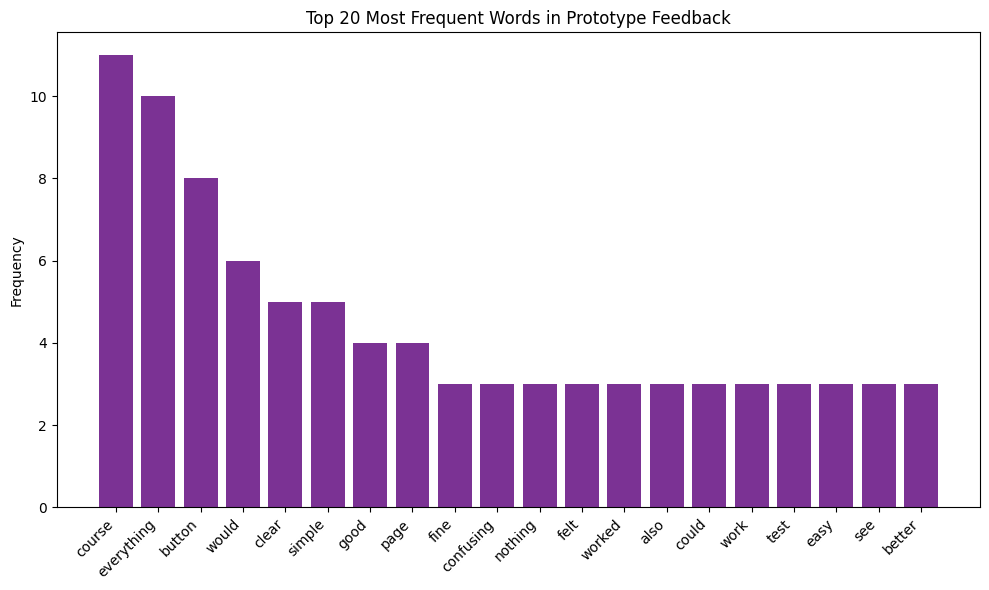

In [ ]:
import matplotlib.pyplot as plt

# Take top 20 lemmas from previous step
words, counts = zip(*lemma_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color="#7b3294")   # clean purple tone
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Prototype Feedback")
plt.tight_layout()
plt.show()


The bar chart highlights the most common words in user feedback.
This gives a quick view of what users focused on when interacting with the prototype:

Words tied to navigation and clarity usually appear at the top.

Mid-frequency words can indicate smaller but recurring points.

This visual helps confirm the early signals before moving to collocations and themes.

#STEP 17 — Bigram Collocations

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    if pd.isna(text) or not str(text).strip():
        return []

    text = text.lower()
    tokens = word_tokenize(text)

    # keep alphabetic words only, remove stopwords
    cleaned = [t for t in tokens if t.isalpha() and t not in stop_words]
    return cleaned

df_proto['tokens'] = df_proto['comments'].apply(clean_and_tokenize)
df_proto[['comments', 'tokens']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,comments,tokens
0,Everything was really good and clear,"[everything, really, good, clear]"
1,-,[]
2,everything is fine and convenient to use,"[everything, fine, convenient, use]"
3,Mabey the text. If I ended up in rigth page af...,"[mabey, text, ended, rigth, page, pressing, ma..."
4,Maybe it wasn’t included because it is just a ...,"[maybe, included, prototype, workflow, seeing,..."


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(t) for t in token_list]

df_proto['lemmas'] = df_proto['tokens'].apply(lemmatize_tokens)
df_proto[['tokens', 'lemmas']].head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,tokens,lemmas
0,"[everything, really, good, clear]","[everything, really, good, clear]"
1,[],[]
2,"[everything, fine, convenient, use]","[everything, fine, convenient, use]"
3,"[mabey, text, ended, rigth, page, pressing, ma...","[mabey, text, ended, rigth, page, pressing, ma..."
4,"[maybe, included, prototype, workflow, seeing,...","[maybe, included, prototype, workflow, seeing,..."


In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# Flatten all lemmas into one list
tokens_for_colloc = df_proto['lemmas'].explode().tolist()

bigram_measures = BigramAssocMeasures()

# Build finder
finder = BigramCollocationFinder.from_words(tokens_for_colloc)

# Only keep pairs appearing at least twice
finder.apply_freq_filter(2)

# Extract top 20 PMI-ranked bigrams
top_bigrams = finder.nbest(bigram_measures.pmi, 20)
top_bigrams


[('pretty', 'understandable'),
 ('could', 'select'),
 ('go', 'back'),
 ('hard', 'test'),
 ('good', 'clear'),
 ('course', 'registration'),
 ('select', 'course'),
 ('button', 'work'),
 ('button', 'worked'),
 ('everything', 'fine'),
 ('everything', 'clear')]

Bigram Collocations — Interpretation

The bigram patterns in the prototype feedback are mostly positive and indicate reduced friction compared to the first survey. Several clusters appear:

1. Clarity and understanding
Phrases like pretty understandable, everything clear, and everything fine show that most users found the redesigned workflows easy to follow.

2. Improved interaction with buttons and actions
Pairs such as button work and button worked highlight that users explicitly noticed functional improvements, especially compared to the current LUIS where actions often do not respond.

3. Course-related actions
Combinations like course registration and select course confirm that users tested the flows as intended and were able to complete the steps without confusion.

4. Minor friction points
Pairs like go back and could select imply occasional uncertainty about navigation or whether certain demo elements were active in the prototype.

Overall, the collocations reveal a much more positive tone than in the original LUIS dataset. The recurring patterns emphasise clarity, functional buttons, and smooth course-selection steps, suggesting a substantial improvement in perceived usability.

# STEP 18 - Wordcloud

In [ ]:
from collections import Counter

# Flatten tokens into one list
all_tokens = [t for row in df_proto['tokens'] for t in row]

# Check first 20 tokens
all_tokens[:20]


['everything',
 'really',
 'good',
 'clear',
 'everything',
 'fine',
 'convenient',
 'use',
 'mabey',
 'text',
 'ended',
 'rigth',
 'page',
 'pressing',
 'marketing',
 'written',
 'marketing',
 'confusing',
 'maybe',
 'included']

In [ ]:
all_tokens = df_proto['tokens'].explode().dropna().tolist()
all_words = " ".join(all_tokens)


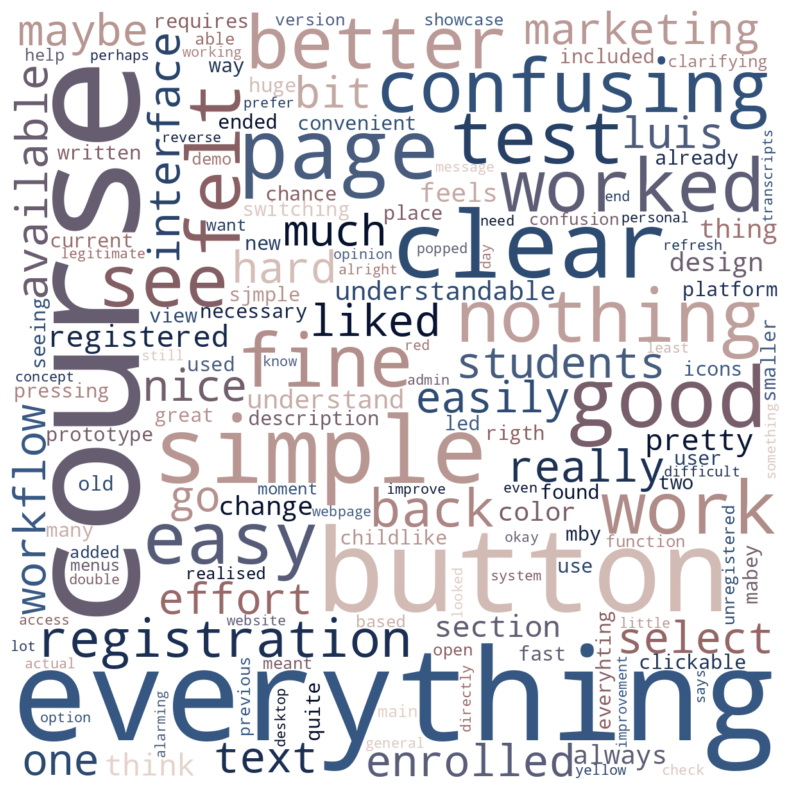

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

deep_pastel_colors = LinearSegmentedColormap.from_list(
    "deep_pastel_theme",
    [
        "#E6D6CE",  # deeper beige
        "#8F5F5F",  # deeper rose taupe
        "#395B85",  # darker slate blue
        "#010A26"   # very deep navy
    ]
)

wc_deep = WordCloud(
    width=1200,
    height=1200,
    background_color="#ffffff",
    colormap=deep_pastel_colors,
    collocations=False,
    max_words=250,
    prefer_horizontal=0.9
).generate(all_words)

plt.figure(figsize=(10,10))
plt.imshow(wc_deep, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
export_path = '/content/drive/MyDrive/Zogota_Thesis_Repository/Workflow_Prototype_Test_Cleaned.csv'

df_proto.to_csv(export_path, index=False)

print("Saved to:", export_path)


Saved to: /content/drive/MyDrive/Zogota_Thesis_Repository/Workflow_Prototype_Test_Cleaned.csv
